In [1]:
import re
import pandas as pd

/var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/ipykernel_38152/1566173301.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
params = [320, 320, 320+18496, 320+18496, 320+18496, 320+18496, 320+18496+16010]

In [3]:
# extract "Elapsed (wall clock) time" in mm:ss.xx format and "Maximum resident set size (kbytes):"

def extract_time_and_mem(filename):
    with open(filename, 'r') as f:
        content = f.read()
        time = re.search(r'Elapsed \(wall clock\) time \(h:mm:ss or m:ss\): (\d+:\d+\.\d+)', content).group(1)
        mem = re.search(r'Maximum resident set size \(kbytes\): (\d+)', content).group(1)
        return time, mem

In [4]:
with open("../circom_compile.out", 'r') as f:
    content = f.read()
    constraints = re.findall(r'non-linear constraints: (\d+)', content)


In [5]:
with open("../ezkl_bench.out", 'r') as f:
    content = f.read()
    rows = re.findall(r'model uses (\d+) rows', content)

with open("../op_bench.out", 'r') as f:
    content = f.read()
    opml_time = re.findall(r'Time taken to run the op model \d+: (\d+.\d+)', content)

opml_time.append('0') # add a dummy value

In [6]:
# read from {circom,ezkl}_bench_{1..7}.out, extract time and memory, and store in a dataframe, split circom and ezkl into two columns, 1-7 into indices

data = []
for i in range(1, 8):
    circom_time, circom_mem = extract_time_and_mem(f'circom_bench_{i}.out')
    ezkl_time, ezkl_mem = extract_time_and_mem(f'ezkl_bench_{i}.out')
    data.append([circom_time, circom_mem, ezkl_time, ezkl_mem])

df = pd.DataFrame(data, columns=['circom_time', 'circom_mem', 'ezkl_time', 'ezkl_mem'])
df.index = range(1, 8)

df

,circom_time,circom_mem,ezkl_time,ezkl_mem
1,4:38.80,85446120,0:33.20,2869864
2,8:44.18,129358852,0:36.45,2857136
3,10:16.60,136911572,3:08.11,22516096
4,10:50.14,138164812,3:08.13,22510672
5,10:43.00,137874072,3:06.55,22514768
6,10:44.07,137311736,3:06.98,22515256
7,11:04.88,137595576,3:11.77,22512552


In [7]:
df['model_params'] = pd.to_numeric(params)

In [8]:
# Convert time columns to hh:mm:ss format
df['circom_time'] = pd.to_datetime(df['circom_time'], format="%M:%S.%f").dt.strftime("%H:%M:%S.%f")
df['ezkl_time'] = pd.to_datetime(df['ezkl_time'], format="%M:%S.%f").dt.strftime("%H:%M:%S.%f")

# Convert time columns to timedelta
df['circom_time'] = pd.to_timedelta(df['circom_time'])
df['ezkl_time'] = pd.to_timedelta(df['ezkl_time'])

# Convert memory columns to integer
df['circom_mem'] = pd.to_numeric(df['circom_mem'])
df['ezkl_mem'] = pd.to_numeric(df['ezkl_mem'])

In [9]:
df['circom_constrs'] = pd.to_numeric(constraints)
df['ezkl_rows'] = pd.to_numeric(rows)

df['opml_time'] = pd.to_numeric(opml_time)
df['opml_time'] = pd.to_timedelta(df['opml_time'] , unit='s')

# remove index 5 and 6

df = df.drop([5, 6])

In [10]:
df['circom_op_time'] = df['circom_time'] + df['opml_time']
df['ezkl_op_time'] = df['ezkl_time'] + df['opml_time']

In [11]:
df

,circom_time,circom_mem,ezkl_time,ezkl_mem,model_params,circom_constrs,ezkl_rows,opml_time,circom_op_time,ezkl_op_time
1,0 days 00:04:38.800000,85446120,0 days 00:00:33.200000,2869864,320,11378432,184408,0 days 00:00:00.040334380,0 days 00:04:38.840334380,0 days 00:00:33.240334380
2,0 days 00:08:44.180000,129358852,0 days 00:00:36.450000,2857136,320,16867552,224968,0 days 00:00:00.039514066,0 days 00:08:44.219514066,0 days 00:00:36.489514066
3,0 days 00:10:16.600000,136911572,0 days 00:03:08.110000,22516096,18816,23101472,1373720,0 days 00:00:00.039434895,0 days 00:10:16.639434895,0 days 00:03:08.149434895
4,0 days 00:10:50.140000,138164812,0 days 00:03:08.130000,22510672,18816,24725472,1385048,0 days 00:00:00.039542312,0 days 00:10:50.179542312,0 days 00:03:08.169542312
7,0 days 00:11:04.880000,137595576,0 days 00:03:11.770000,22512552,34826,24741472,1392273,0 days 00:00:00,0 days 00:11:04.880000,0 days 00:03:11.770000


In [12]:
# divide df by last row to get %, if last row is 0, replace with 1 to avoid division by zero

fd = df[['circom_mem', 'ezkl_mem', 'circom_time', 'ezkl_time', 'circom_constrs', 'ezkl_rows']]
fd = (fd.div(fd.iloc[-1], axis=1) * 100).round().astype(int)
fd

,circom_mem,ezkl_mem,circom_time,ezkl_time,circom_constrs,ezkl_rows
1,62,12,41,17,45,13
2,94,12,78,19,68,16
3,99,100,92,98,93,98
4,100,99,97,98,99,99
7,100,100,100,100,100,100


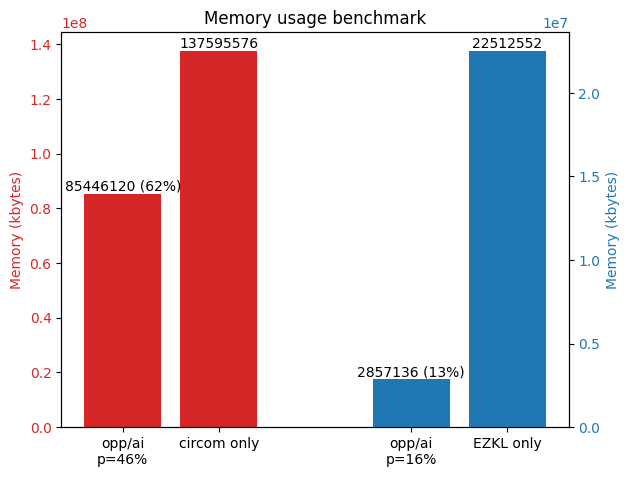

In [13]:
import matplotlib.pyplot as plt
# bar plot of only the first and last value of circom_mem

circom_mem = df['circom_mem'].iloc[[0, -1]].values
ezkl_mem = df['ezkl_mem'].iloc[[1, -1]].values

# get % of model size
circom_size = (df['circom_constrs'].iloc[0] / df['circom_constrs'].iloc[-1] * 100).round().astype(int)
ezkl_size = (df['ezkl_rows'].iloc[1] / df['ezkl_rows'].iloc[-1] * 100).round().astype(int)

# plot circom_mem and ezkl_mem side by same in the same plot, use circom_mem_pct and ezkl_mem_pct as x ticks, use two y axes

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_ylabel('Memory (kbytes)', color=color)
ax1.bar([-2,-1], circom_mem, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# add labels to the bar
ax1.text(-2, circom_mem[0] + 1e6, f"{circom_mem[0]} ({(circom_mem[0]/circom_mem[-1]*100).round().astype(int)}%)", color='black', ha='center')
ax1.text(-1, circom_mem[1] + 1e6, f"{circom_mem[1]}", color='black', ha='center')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Memory (kbytes)', color=color)  # we already handled the x-label with ax1
ax2.bar([1,2], ezkl_mem, color=color)
ax2.xaxis.set_ticks([-2,-1,1,2])
ax2.xaxis.set_ticklabels([f"opp/ai\np={circom_size}%", 'circom only', f"opp/ai\np={ezkl_size}%", 'EZKL only'])
ax2.tick_params(axis='y', labelcolor=color)

# add labels to the bar
ax2.text(1, ezkl_mem[0] + 2e5, f"{ezkl_mem[0]} ({(ezkl_mem[0]/ezkl_mem[-1]*100).round().astype(int)}%)", color='black', ha='center')
ax2.text(2, ezkl_mem[1] + 2e5, f"{ezkl_mem[1]}", color='black', ha='center')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title('Memory usage benchmark')
plt.show()

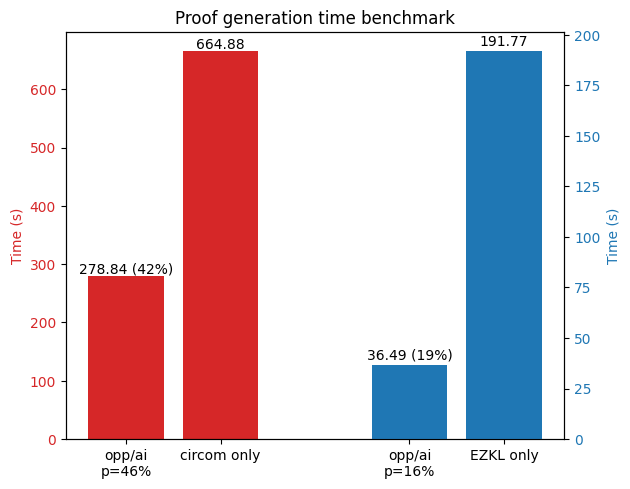

In [14]:
import matplotlib.pyplot as plt
# bar plot of only the first and last value of circom_time

circom_time = df['circom_op_time'].iloc[[0, -1]].values / pd.Timedelta('1s')
ezkl_time = df['ezkl_op_time'].iloc[[1, -1]].values / pd.Timedelta('1s')

# plot circom_time and ezkl_time side by same in the same plot, use circom_time_pct and ezkl_time_pct as x ticks, use two y axes

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_ylabel('Time (s)', color=color)
ax1.bar([-2,-1], circom_time, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# add labels to the bar
ax1.text(-2, circom_time[0] + 5, f"{circom_time[0].round(2)} ({(circom_time[0]/circom_time[-1]*100).round().astype(int)}%)", color='black', ha='center')
ax1.text(-1, circom_time[1] + 5, f"{circom_time[1]}", color='black', ha='center')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Time (s)', color=color)  # we already handled the x-label with ax1
ax2.bar([1,2], ezkl_time, color=color)
ax2.xaxis.set_ticks([-2,-1,1,2])
ax2.xaxis.set_ticklabels([f"opp/ai\np={circom_size}%", 'circom only', f"opp/ai\np={ezkl_size}%", 'EZKL only'])
ax2.tick_params(axis='y', labelcolor=color)

# add labels to the bar
ax2.text(1, ezkl_time[0] + 3, f"{ezkl_time[0].round(2)} ({(ezkl_time[0]/ezkl_time[-1]*100).round().astype(int)}%)", color='black', ha='center')
ax2.text(2, ezkl_time[1] + 3, f"{ezkl_time[1]}", color='black', ha='center')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title('Proof generation time benchmark')
plt.show()

In [15]:
df.to_csv('bench.csv')